# Определение возраста покупателей

## Исследовательский анализ данных

In [3]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# Размер выборки
labels_df = pd.read_csv('/datasets/faces/labels.csv')
sample_size = labels_df.shape[0]
display(labels_df.info())
print("Размер выборки:", sample_size)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

Размер выборки: 7591


In [9]:
labels_df.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


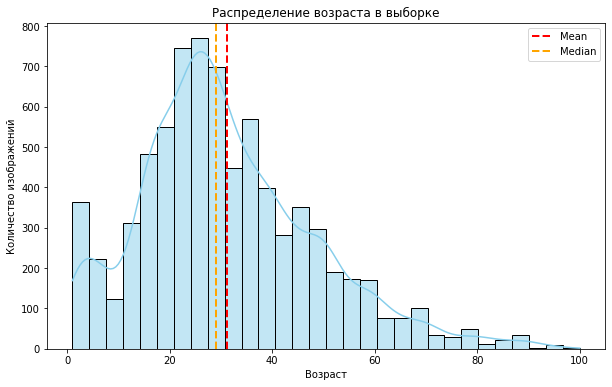

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(labels_df['real_age'], bins=30, kde=True, color='skyblue')
plt.axvline(labels_df['real_age'].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(labels_df['real_age'].median(), color='orange', linestyle='dashed', linewidth=2, label='Median')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.legend()
plt.show()
labels_df.describe().transpose()

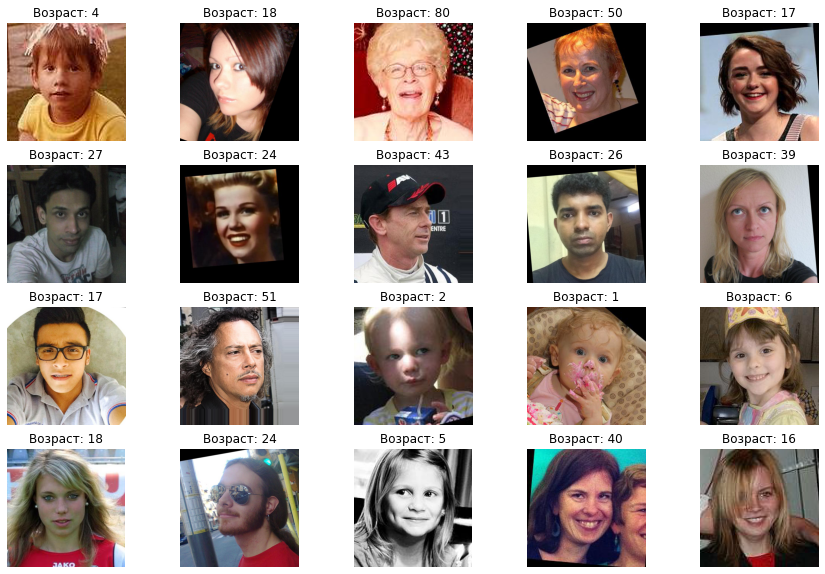

In [4]:
# Визуальный анализ датасета
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
for i in range(20):
    img = plt.imread('/datasets/faces/final_files/' + labels_df['file_name'][i])
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_title('Возраст: ' + str(labels_df['real_age'][i]))
    ax.axis('off')
plt.show()


- Размер выборки составляет 7591 файл,  средний возраст людей на фото составляет 31 год, медианный - 29, минимум и максимум, 1 год и 100 лет.
- Соответственно модель будет распозновать лучше людей возраста 20-40 лет и хуже остальных, потому что меньше выборка 
- Также на некоторых фотографиях люди в очках, с повернутыми лицами, что осложняет обучение 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

 
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25, 
        horizontal_flip=True, 
        rescale=1/255
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=1
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=1
    )
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    ) 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model
 
def train_model(model, train_data, test_data, 
    batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    
    model.fit(
        train_data, 
        validation_data=test_data,
        batch_size=batch_size, 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

```

```

# Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 54s - loss: 182.2523 - mae: 10.1995 - val_loss: 829.8640 - val_mae: 23.8748
Epoch 2/10
356/356 - 44s - loss: 74.8495 - mae: 6.6652 - val_loss: 346.3336 - val_mae: 15.8635
Epoch 3/10
356/356 - 44s - loss: 53.4223 - mae: 5.5766 - val_loss: 110.1421 - val_mae: 7.8351
Epoch 4/10
356/356 - 44s - loss: 45.4185 - mae: 5.1499 - val_loss: 87.1266 - val_mae: 7.2621
Epoch 5/10
356/356 - 43s - loss: 38.7552 - mae: 4.7762 - val_loss: 90.7062 - val_mae: 7.2646
Epoch 6/10
356/356 - 43s - loss: 33.8639 - mae: 4.4833 - val_loss: 87.9873 - val_mae: 6.9981
Epoch 7/10
356/356 - 44s - loss: 33.1435 - mae: 4.4005 - val_loss: 86.8866 - val_mae: 7.1189
Epoch 8/10
356/356 - 44s - loss: 31.5656 - mae: 4.3353 - val_loss: 80.0810 - val_mae: 7.0065
Epoch 9/10
356/356 - 44s - loss: 29.6859 - mae: 4.1771 - val_loss: 77.6999 - val_mae: 6.7073
Epoch 10/10
356/356 - 43s - loss: 27.1789 - mae: 4.0068 - val_loss: 82.0573 - val_mae: 6.8793


119/119 - 11s - loss: 82.0573 - mae: 6.8793
Test MAE: 6.8793


```

## Анализ обученной модели

- Используя предуобученную модель ResNet можно получить очень хорошие результаты при работе с различными объектами и свойствами фотографий
- в данной работе целевым признаком был возраст человека на фото, 
- по метрике видно, что средняя абсолютная ошибка распознавания возраста в пределах 7 лет на тестовой выборке, что достаточно для нашей задачи, определение возрастной группы 
- Данная модель способна решить бизнес задачу по разделению людей на категориии